# Forecasting Daily Paediatric Emergency Department Attendances

## Executive Summary

This work forecasts the daily paediatric emergency department (ED) attendances for the next 28 days to inform staffing decisions on the ward. Historic data for daily paediatric ED attendances were used to find the best model to predict a 28-day horizon of the known data using cross-validation, which was found to be the Prophet model. The point forecast was assessed using mean absolute error, and Winkler score was used to assess prediction intervals. The future forecast using Prophet predicted that the number of attendances would generally increase over the next 28 days, with the lowest predicted attendance being 46 compared to the highest at 67. However, despite this model being the best one found, the point forecast often under-predicted the actual attendance, which should be taken into consideration when using the forecast to inform staffing decisions.

## Contents

[1. Introduction](#section1)<br>
[2. Objectives](#section2)<br>
[3. Methods](#section3)<br>
[4. Results](#section4)<br>
[5. Discussion](#section5)<br>
[6. Conclusion](#section6)<br>
[7. References](#section7)<br>

<a id="section1"></a>
## 1. Introduction

Forecasting models can provide an estimate of future outcomes based on past trends. Using historic data on previous daily paediatric ED attendances can produce a predictive model, enabling a future forecast to be produced. Such models can be used to inform ED staffing decisions, which are vital to ensuring patient safety and satisfaction, and ensuring optimal care is delivered. Inadequate staffing adversely affects patients’ outcomes and can increase the chance of staff turnover (DeRienzo *et al.*, 2017).

<a id="section2"></a>
## 2. Objectives 

The aim is to provide a forecast of daily paediatric ED attendances to inform staffing decisions over the next 28-day period. A forecasting model’s predictive capability be compared against naive benchmark models. The best model will be identified by comparing error metrics and Winkler score using cross-validation, which tests how well the model performs on unseen data and is protected against overfitting. This model will then be used to forecast attendances over the next 28 days, which could be useful in informing staffing decisions during this period based on predicted changes in attendance.

<a id="section3"></a>
## 3. Methods

Initially, the data set is investigated to check the format, length of data and the dates it covers. The data will be split into a training set, chosen as all data except the last 28 days. The test set, the last 28 days, will be plotted against the point forecast to visually assess how the model performs. The best model will be chosen using cross-validation of a 28-day horizon. The first models to be investigated are simple naive forecasting models, to be used as benchmark models. Then, more complex models will be investigated, namely ARIMA, Regression with ARIMA Errors, Prophet and a feedforward neural network. The aim is to find a better model than the best benchmark model as it is important that any more complex model chosen outperforms this model. The best model is taken forward to predict attendances over the next 28 days.

### 3.1 Imports

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import sys

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports used for creating baseline naive model
from forecast_tools.baseline import (baseline_estimators,
                                     Average)

from forecast_tools.model_selection import (cross_validation_score,
                                            cross_validation_folds)

from forecast_tools.metrics import (root_mean_squared_error,
                                    mean_absolute_error,
                                    mean_absolute_percentage_error,
                                    symmetric_mean_absolute_percentage_error,
                                    winkler_score)

In [3]:
# Imports required for the ARIMA model
from pmdarima import auto_arima, ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [4]:
# Imports required for the Prophet model
from prophet import Prophet
import prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import (plot_cross_validation_metric,
                          plot_plotly, plot_components_plotly,
                          add_changepoints_to_plot)

In [5]:
# Suppresses cmdstanpy info when running Prophet model
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [6]:
#  Tensorflow imports for neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Used for pre-processing and evaluation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import meanabs

2024-02-15 12:05:51.305435: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 12:05:51.349972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3.2 Data Exploration

In [7]:
# Reads in data and sets the time frequency as daily
attends = pd.read_csv('paediatrics_train.txt', index_col='date',
                      parse_dates=True, dayfirst=False)
attends.index.freq = 'D'

In [8]:
# Ensures the format and length is as expected with the correct datatime index
print(attends.index)

DatetimeIndex(['2014-04-01', '2014-04-02', '2014-04-03', '2014-04-04',
               '2014-04-05', '2014-04-06', '2014-04-07', '2014-04-08',
               '2014-04-09', '2014-04-10',
               ...
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19'],
              dtype='datetime64[ns]', name='date', length=1056, freq='D')


In [9]:
# Checking datetime index has correctly identified days
print(attends.index.day)

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
      dtype='int32', name='date', length=1056)


In [10]:
# Checking datetime index has correctly identified months
print(attends.index.month)

Index([4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       ...
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype='int32', name='date', length=1056)


In [11]:
# Checking datetime index has correctly identified the years
print(attends.index.year)

Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       ...
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
      dtype='int32', name='date', length=1056)


In [12]:
# Number of days in time series
attends.shape

(1056, 1)

In [13]:
# Minimum date
attends.index.min()

Timestamp('2014-04-01 00:00:00')

In [14]:
# Maximum date
attends.index.max()

Timestamp('2017-02-19 00:00:00')

The first few lines of data show the number of daily paediatric ED attendances from the start date, which is useful in understanding the approximate number of daily attendances.

In [15]:
attends.head()

paed_ed_attends
date                       
2014-04-01               47
2014-04-02               46
2014-04-03               47
2014-04-04               48
2014-04-05               52

In [16]:
# Sets up the training data
train = attends.iloc[:-28]

# Number of days in time series
train.shape

(1028, 1)

In [17]:
# Maximum date to check assignment of training set
train.index.max()

Timestamp('2017-01-22 00:00:00')

In [18]:
train.describe()

paed_ed_attends
count      1028.000000
mean         49.391051
std           9.478043
min          21.000000
25%          43.000000
50%          49.000000
75%          56.000000
max          85.000000

In [19]:
# Test set is the last 28 days of the known data
test = attends.iloc[-28:]

test.shape

(28, 1)

A plot of the paediatric ED attendances training set is shown below. Some general trends can be seen in the data, for example, a drop in attendances between July and September which rises again from October to December before once more falling in late December and January.

Text(0, 0.5, 'Paediatric ED Attendances')

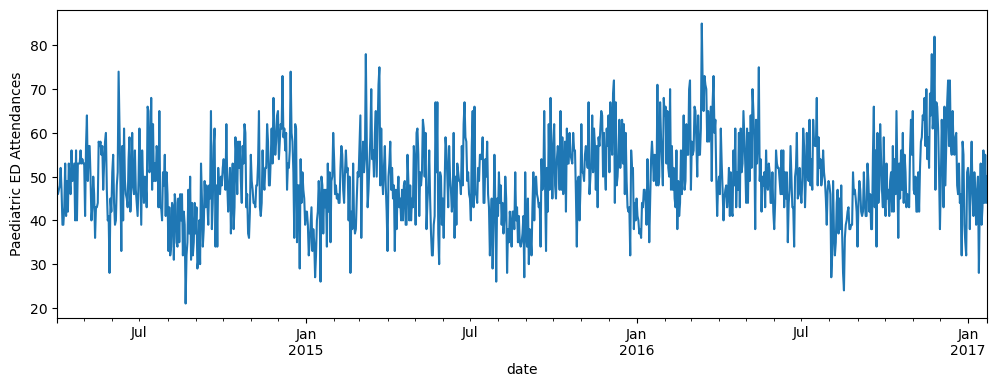

In [20]:
ax = train.plot(figsize=(12,4), legend=False)
ax.set_ylabel('Paediatric ED Attendances')

In [21]:
# Autocorrelation plot of training data
plot_acf(train);

### 3.3 Naive Benchmark

In order to ensure the quality of a forecasting model, it is important to compare it to a naive benchmark model. The best naive model is identified using the metrics root mean squared error (RMSE), mean absolute error (MAE) and symmetric mean absolute percentage error (sMAPE).

In [22]:
def rolling_forecast_origin(train, min_train_size, horizon, step=1):
    '''
    Generator function that uses the rolling forecast method to create sets
    of test/train data.

    Parameters:
    -----------
    train: pd.DataFrame
        Data to be split.
    min_train_size: int
        Size of first set of training data.
    horizon: int
        How far into the future to predict.
    step: int, optional (default=1)
        How much to increase size of training window by each time.

    Returns:
    --------
    split_train: pd.DataFrame
        Training data.
    split_test: pd.DataFrame
        Test data.
    '''
    for i in range((len(train) - min_train_size - horizon + 1)//step):
        s = i*step # Changes size of train set depending on step
        split_train = train[:min_train_size+s]
        split_test = train[min_train_size+s:min_train_size+s+horizon]
        yield split_train, split_test

In [23]:
# Import baseline estimators using the daily seasonal period
estimators = baseline_estimators(seasonal_period=7)

In [24]:
# Investigate 3 different metrics to identify the best model
metrics = {'rmse' : root_mean_squared_error,
           'mae' : mean_absolute_error,
           'smape' : symmetric_mean_absolute_percentage_error}
min_train_size = len(attends) // 3

# Stores results in a dictionary
rmse_results = {}
mae_results = {}
smape_results = {}
for name, model in estimators.items():
    for score_name, met in metrics.items():
        # Uses cross-validation to evaluate models
        cv = rolling_forecast_origin(train=train,
                                     min_train_size=min_train_size,
                                     horizon=28)
        scores = cross_validation_score(model=model, cv=cv,
                                        metric=met,
                                        n_jobs=-1)
        # Finds mean of all scores from the cross-validation method
        av_score = scores.mean()
        if score_name == 'rmse':
            rmse_results[name] = av_score
        elif score_name == 'mae':
            mae_results[name] = av_score
        elif score_name == 'smape':
            smape_results[name] = av_score

In [25]:
mae_results

{'NF1': 9.637354171252476,
 'SNaive': 9.900600610043709,
 'Average': 7.652382415322031,
 'Drift': 9.754801120812477,
 'Ensemble': 8.186609666370055}

In [26]:
print(f'Lowest RMSE: {round(min(rmse_results.values()), 5)} '
      f'({min(rmse_results, key=rmse_results.get)})')
print(f'Lowest MAE: {round(min(mae_results.values()), 5)} '
      f'({min(mae_results, key=mae_results.get)})')
print(f'Lowest sMAPE: {round(min(smape_results.values()), 5)} '
      f'({min(smape_results, key=smape_results.get)})')

Lowest RMSE: 9.44091 (Average)
Lowest MAE: 7.65238 (Average)
Lowest sMAPE: 15.40656 (Average)


The best naive benchmark identified using these metrics was the Average model, which is therefore selected as the baseline model.

### 3.4 Autoregressive Integrated Moving Average (ARIMA) Model

Text(0, 0.5, 'Attends')

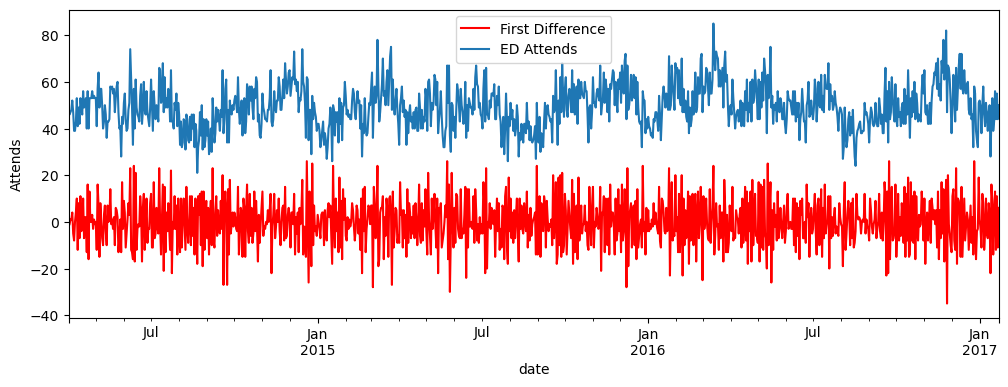

In [27]:
# Plot of the first difference of the time series, represented by the q-value
first_diff = train.diff()
ax = first_diff.plot(figsize=(12,4), color='red')
train.plot(ax=ax)
ax.legend(['First Difference', 'ED Attends'])
ax.set_ylabel('Attends')

Auto ARIMA is used to select the best ARIMA model. The results were used to manually create an ARIMA model to avoid searching through all possible models each time the code is run. This selected the values of (p, d, q)x(P, D, Q, m) as (0, 1, 1)x(0, 0, 2, 7). However, 1 was chosen as the seasonal autoregressive order (P) for the final model because the plot above shows a seasonal cycle. Adding this parameter ensures the model takes into account observations from the previous season. It also improved the Akaike information criterion (AIC) from 7214 to 7183, suggesting this change improved the model fit.

In [28]:
#arima_model = auto_arima(train, m=7, supress_warnings=True)
# Auto selected: order=(0, 1, 1), seasonal_order=(0, 0, 2, 7)
# Added seasonal autoregressive order 1 in chosen model

arima_model = ARIMA(order=(0, 1, 1), seasonal_order=(1, 0, 2, 7),
                    suppress_warnings=True)

arima_model.fit(train)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1028
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -3585.690
Date:                                Thu, 15 Feb 2024   AIC                           7183.380
Time:                                        12:06:02   BIC                           7212.987
Sample:                                    04-01-2014   HQIC                          7194.618
                                         - 01-22-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.491e-05      0.000     -0.072      0.943      -0.001       0.001
ma.L1         -0.8033      0.018    -43.913      0.000      -0.839      -0.767
ar.S.L7        0.9974      0.006    162.367      0.000       0.985       1.009
ma.S.L7       -0.9689      0.034    -28.389      0.000      -1.036      -0.902
ma.S.L14      -0.0157      0.033     -0.477      0.634      -0.080       0.049
sigma2        63.7329      2.948     21.615      0.000      57.954      69.512
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.65   Prob(JB):                         0.92
Heteroskedasticity (H):               1.00   Skew:                             0.03
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5 Prophet Model

In [29]:
def training_data_prophet(y_train):
    '''
    Turns pd.DataFrame with a datetime stamp into a format suitable for
    use in the Prophet model.

    Parameters:
    ----------
    y_train: pd.DataFrame
        Training data (time series).

    Returns:
    --------
    prophet_train: pd.DataFrame
        Training data in Prophet format.
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

In [30]:
def make_prophet_model(interval=0.95, add_holidays=True, add_monthly=True):
    '''
    Creates Prophet model object with required parameters.

    Parameters:
    ----------
    interval: float, optional (default=0.95)
        Prediction interval to use.
    add_holidays: bool, optional (default=True)
        Whether to add effect of UK holidays to model.
    add_monthly: bool, optional (default=True)
        Whether to add monthly seasonality to model.

    Returns:
    --------
    prophet_model: model object
        Prophet model.
    '''
    # Creates model with the required prediction interval
    prophet_model = Prophet(interval_width=interval)

    # Effect of UK holidays on attendances
    if add_holidays:
        prophet_model.add_country_holidays(country_name='UK')

    # Effect of day of month on attendances
    if add_monthly:
        prophet_model.add_seasonality(name='monthly', period=30.5,
                                      fourier_order=5)

    return prophet_model

In [31]:
def create_prophet_forecast(prophet_model, train, periods=28):
    '''
    Creates forecast using Prophet model.

    Parameters:
    ----------
    prophet_model: model object
        Prophet model.
    train: pd.DataFrame
        Training data to fit the model to.
    periods: int, optional (default=28)
        Number of periods to predict.

    Returns:
    --------
    prophet_model: model object
        Prophet model.
    '''
    # Uses function to create training data in suitable format
    prophet_train = training_data_prophet(train)
    # Fits training data to the model
    prophet_model.fit(prophet_train)

    # Makes future data frame to predict with
    future = prophet_model.make_future_dataframe(periods=periods)
    prophet_forecast = prophet_model.predict(future)

    return prophet_forecast

In [32]:
# Creates model and makes predictions
prophet_model = make_prophet_model()
prophet_forecast = create_prophet_forecast(prophet_model, train)
prophet_forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-04-01  49.750840   34.891067   63.429919    49.750840    49.750840   
1 2014-04-02  49.744048   34.388226   62.055335    49.744048    49.744048   
2 2014-04-03  49.737256   32.562990   60.554005    49.737256    49.737256   
3 2014-04-04  49.730464   32.955370   61.441203    49.730464    49.730464   
4 2014-04-05  49.723672   31.151390   59.213838    49.723672    49.723672   

   Boxing Day  Boxing Day_lower  Boxing Day_upper  Boxing Day (Observed)  ...  \
0         0.0               0.0               0.0                    0.0  ...   
1         0.0               0.0               0.0                    0.0  ...   
2         0.0               0.0               0.0                    0.0  ...   
3         0.0               0.0               0.0                    0.0  ...   
4         0.0               0.0               0.0                    0.0  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0 -1.867210     -1.867210     -1.867210  0.588831      0.588831      0.588831   
1 -1.698862     -1.698862     -1.698862 -0.402910     -0.402910     -0.402910   
2 -1.520136     -1.520136     -1.520136 -1.322697     -1.322697     -1.322697   
3 -0.336209     -0.336209     -0.336209 -2.158232     -2.158232     -2.158232   
4 -0.230423     -0.230423     -0.230423 -2.898939     -2.898939     -2.898939   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  48.438877  
1                         0.0  47.865047  
2                         0.0  46.751250  
3                         0.0  46.549801  
4                         0.0  45.698776  

[5 rows x 52 columns]

### 3.6 Regression with ARIMA Errors

In [33]:
def seasonal_indexes(idx):
    '''
    Creates DataFrame with dummy variables representing the month of the year
    and day of the week.

    Parameters:
    ----------
    idx: pd.DateTimeIndex
        Index of the data to create seasonal indexes for.

    Returns:
    --------
    prophet_train: pd.DataFrame
        Training data in Prophet format.
    '''
    X = pd.DataFrame()
    # Creates dummy variables for month of year
    X = pd.concat([X, pd.get_dummies(idx.month, prefix='m',
                                     drop_first=True, dtype=int)], axis=1)
    # Creates dummy variables for day of week
    X = pd.concat([X, pd.get_dummies(idx.weekday, prefix='dow',
                                     drop_first=True, dtype=int)], axis=1)
    X.index = idx

    return X

In [34]:
# Create seasonal indexes for the training data
reg_exog = seasonal_indexes(train.index)
reg_exog.tail()

m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  m_10  m_11  m_12  dow_1  \
date                                                                          
2017-01-18    0    0    0    0    0    0    0    0     0     0     0      0   
2017-01-19    0    0    0    0    0    0    0    0     0     0     0      0   
2017-01-20    0    0    0    0    0    0    0    0     0     0     0      0   
2017-01-21    0    0    0    0    0    0    0    0     0     0     0      0   
2017-01-22    0    0    0    0    0    0    0    0     0     0     0      0   

            dow_2  dow_3  dow_4  dow_5  dow_6  
date                                           
2017-01-18      1      0      0      0      0  
2017-01-19      0      1      0      0      0  
2017-01-20      0      0      1      0      0  
2017-01-21      0      0      0      1      0  
2017-01-22      0      0      0      0      1

In [35]:
# Fit ARIMA model using dummy variable matrix
reg_arima_err_model = auto_arima(train, X=reg_exog, m=7,
                                 supress_warnings=True, maxiter=100)

reg_arima_err_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1028
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3566.458
Date:                Thu, 15 Feb 2024   AIC                           7170.917
Time:                        12:07:21   BIC                           7264.670
Sample:                    04-01-2014   HQIC                          7206.503
                         - 01-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
m_2            0.8874      3.933      0.226      0.821      -6.820       8.595
m_3            5.2664      4.583      1.149      0.251      -3.716      14.249
m_4           -0.8007      5.021     -0.159      0.873     -10.642       9.041
m_5           -0.1327      5.197     -0.026      0.980     -10.318      10.053
m_6            2.4582      5.269      0.467      0.641      -7.869      12.786
m_7            4.5835      5.261      0.871      0.384      -5.727      14.894
m_8           -1.2329      5.176     -0.238      0.812     -11.377       8.911
m_9           -0.5395      4.853     -0.111      0.911     -10.050       8.971
m_10           0.1775      4.489      0.040      0.968      -8.620       8.975
m_11           3.6612      3.888      0.942      0.346      -3.958      11.281
m_12           3.1090      3.488      0.891      0.373      -3.727       9.945
dow_1         -4.5371      0.874     -5.190      0.000      -6.251      -2.824
dow_2         -4.4382      0.850     -5.219      0.000      -6.105      -2.771
dow_3         -4.3400      0.787     -5.516      0.000      -5.882      -2.798
dow_4         -2.9014      0.867     -3.348      0.001      -4.600      -1.203
dow_5         -2.7921      0.891     -3.134      0.002      -4.538      -1.046
dow_6          0.3412      0.803      0.425      0.671      -1.233       1.915
ma.L1         -0.8195      0.019    -43.985      0.000      -0.856      -0.783
sigma2        60.7305      2.746     22.113      0.000      55.348      66.113
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.62   Prob(JB):                         0.91
Heteroskedasticity (H):               1.03   Skew:                             0.03
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Calculates future indexes for the test set
reg_arima_err_idx = pd.date_range(start=train.iloc[-1].name,
                                  periods=train.shape[0]+28, freq='D')

# Creates dummy variable matrix for months and days
reg_arima_err_future = seasonal_indexes(reg_arima_err_idx).iloc[1:29]
reg_arima_err_future.tail()

m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  m_10  m_11  m_12  dow_1  \
2017-02-15    1    0    0    0    0    0    0    0     0     0     0      0   
2017-02-16    1    0    0    0    0    0    0    0     0     0     0      0   
2017-02-17    1    0    0    0    0    0    0    0     0     0     0      0   
2017-02-18    1    0    0    0    0    0    0    0     0     0     0      0   
2017-02-19    1    0    0    0    0    0    0    0     0     0     0      0   

            dow_2  dow_3  dow_4  dow_5  dow_6  
2017-02-15      1      0      0      0      0  
2017-02-16      0      1      0      0      0  
2017-02-17      0      0      1      0      0  
2017-02-18      0      0      0      1      0  
2017-02-19      0      0      0      0      1

In [37]:
# Check the index is the same as for the test set
reg_arima_err_future.index

DatetimeIndex(['2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26',
               '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05', '2017-02-06', '2017-02-07',
               '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-11',
               '2017-02-12', '2017-02-13', '2017-02-14', '2017-02-15',
               '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19'],
              dtype='datetime64[ns]', freq='D')

### 3.7 Forecast Prophet Residuals Using ARIMA

It is noted by Elseidi (2023a) that the Prophet model is a good choice for daily level data as it can handle complex seasonal effects and is robust to outliers and changes in trends. However, they state that it does not capture short-term correlations and fluctuations, or irregular patterns well. One method of testing this is by first fitting a Prophet model to the data, then fitting an ARIMA model to the residuals and averaging the results to better capture the full trend.

In [38]:
# Finds predictions of the training set only
prophet_preds = prophet_forecast.loc[:,'yhat'][:-28]

# Calculates residuals (difference between actual and predicted)
resids = []
for ind, result in enumerate(train['paed_ed_attends']):
    resid = result - prophet_preds.iloc[ind]
    resids.append(resid)

In [39]:
# Creates new DataFrame with DateTimeIndex and residuals
prophet_resids = pd.DataFrame(train.index)
prophet_resids['date'] = pd.to_datetime(prophet_resids['date'])
prophet_resids.set_index('date', inplace=True)
prophet_resids.index.freq = 'D'
prophet_resids['resids'] = resids
prophet_resids.head()

resids
date                
2014-04-01 -1.438877
2014-04-02 -1.865047
2014-04-03  0.248750
2014-04-04  1.450199
2014-04-05  6.301224

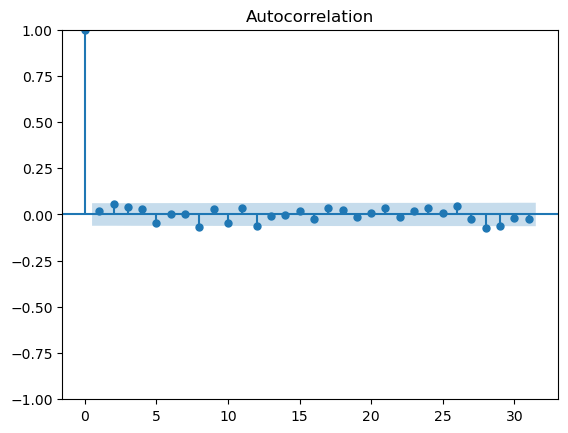

In [40]:
# Plots autocorrelation or residuals
plot_acf(prophet_resids);

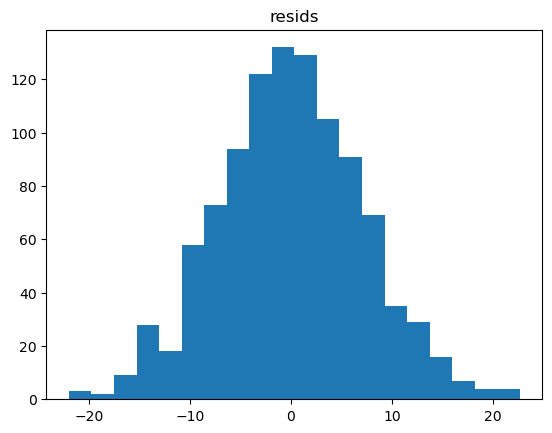

In [41]:
_ = prophet_resids.hist(bins=20, grid=False)

In [42]:
# Uses auto ARIMA to fit best model to the residuals
arima_resid_model = auto_arima(prophet_resids, m=7,
                               supress_warnings=True)
arima_resid_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1028
Model:                        SARIMAX   Log Likelihood               -3479.383
Date:                Thu, 15 Feb 2024   AIC                           6960.765
Time:                        12:07:24   BIC                           6965.701
Sample:                    04-01-2014   HQIC                          6962.639
                         - 01-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        50.9757      2.228     22.882      0.000      46.609      55.342
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.50   Prob(JB):                         0.54
Heteroskedasticity (H):               1.03   Skew:                             0.08
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# Makes predictions over the next 28 day period
resid_preds, resid_int = arima_resid_model.predict(n_periods=28, alpha=0.2,
                                                   return_conf_int=True)

In [44]:
# Check if any trend was predicted in the residuals
resid_preds.head()

2017-01-23    0.0
2017-01-24    0.0
2017-01-25    0.0
2017-01-26    0.0
2017-01-27    0.0
Freq: D, dtype: float64

The ARIMA model could not detect any trend or seasonality in the random errors produced by the Prophet model, meaning the errors were stationary.

### 3.8 Feedforward Neural Network

In [45]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    Sliding window that puts data in a format used by the neural network.

    Parameters:
    -----------
    train: array-like
        Training data.
    window_size: int, optional (default=2)
        Lookback (how much lagged data to include).
    horizon: int, optional (default=1)
        Number of observations ahead to predict.

    Returns:
    ---------
    Preprocessed X: array-like

    Preprocessed Y: array-like
    '''
    tabular_X = []
    tabular_y = []

    for i in range(0, len(train) - window_size - horizon + 1):
        X_train = train.iloc[i:window_size+i]
        y_train = train.iloc[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)

    return (np.asarray(tabular_X),
            np.asarray(tabular_y).reshape(-1, ))

In [46]:
def array_test_train_split(*arrays, train_size):
    '''
    Performs test/train split.

    Parameters:
    -----------
    arrays: np.ndarray
        Arrays to be split.
    train_size: int
        Size of training set.

    Returns:
    ---------
    Results:
        Test/train split of each array.
    '''
    results = ()
    for arr in arrays:
        results += arr[:train_size], arr[train_size:]

    return results

In [47]:
window_size = 28
# Creates X and y data required for neural network
X_data, y_data = sliding_window(attends, window_size=window_size,
                                horizon=28)

# Splits into test/train sets
train_size = len(y_data) - 28
X_train, X_test, y_train, y_test = array_test_train_split(X_data, y_data,
                                                        train_size=train_size)

In [48]:
def scale_arrays_of_X(X_to_scale, scaler):
    '''
    Transforms data using a sklearn scaler.

    Parameters:
    ------------
    X_to_scale: np.ndarray
        Sliding windows of X data.
    scaler: MinMaxScaler
        Fitted scaler used to transform X_train.

    Returns:
    -------
    X_scaled: np.ndarray
        Scaled data with dimensions the same as X_train.
    '''
    X_scaled = []

    for sample in X_to_scale:
        # Scale the sample and store in list
        scaled_sample = scaler.transform(sample.reshape(-1, 1))
        X_scaled.append(scaled_sample)

    # Scaled data returned as np.ndarray with same dimensions as input
    return np.array(X_scaled).reshape(len(X_scaled), -1)

In [49]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# Scale on training data to fit
scaler.fit(train.iloc[:-28].to_numpy().reshape(-1, 1))

# Scale all data
y_train = scaler.transform(y_train.reshape(-1, 1))
X_train = scale_arrays_of_X(X_train, scaler)
X_test = scale_arrays_of_X(X_test, scaler)
y_test = scaler.transform(y_test.reshape(-1, 1))

In [50]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive model using the iterative
    prediction method.

    Conduct h one-step forecasts gradually replacing ground truth
    autoregressive X values with predictions.

    Parameters:
    -----------
    model: forecast object
        Model that has a .predict(h) interface.
    exog: array-like
        Initial vector of lagged values (X).
    h: int
        Forecast horizon. Assumed to be > 0.

    Returns:
    --------
    numpy.ndarray
        Predictions.
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        # Uses model to get predictions
        y_pred = model.predict(current_X.reshape(1, -1), verbose=None)[0,0]
        y_preds.append(y_pred)

        # Adds prediction to the current_X list to be used in next prediction
        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [51]:
def get_network_model(window_size, lr=0.01, include_2hidden=False, n_neuron1=5,
                      n_neuron2=15, include_drop_out=False, drop_out_rate=0.2,
                      metrics=['mse']):
    '''
    Sequential Keras MLP model.

    Parameters:
    -----------
    window_size: int
        Size of lookback.
    lr: float, optional (default=0.01)
        Learning rate of NN.
    include_2hidden: bool, optional (default=False)
        Whether a second hidden layer should be used.
    n_neuron1: int, optional (default=5)
        Number of neurons in first hidden layer.
    n_neuron2: int, optional (default=15)
        Number of neurons in second hidden layer.
    include_drop_out: bool, optional (default=False)
        If included, some neurons are dropped out during training.
    drop_out_rate: float, optional (default=0.2)
        How many neurons to drop out.
    metrics: list of str, optional (default=['mse'])
        Model metrics.

    Returns:
    --------
    model: model object
        Sequential neural network.

    '''
    model = Sequential()

    model.add(Flatten(input_shape=(window_size,)))
    # Hidden Layer 1
    model.add(Dense(units=n_neuron1, activation='relu'))
    # Hidden Layer 2
    if include_2hidden:
        model.add(Dense(units=n_neuron2, activation='relu'))
    # Drop-out
    if include_drop_out:
        model.add(Dropout(drop_out_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics=metrics)

    return model

In [52]:
# Random seed to ensure repeatability
tf.keras.utils.set_random_seed(1234)

n_epochs = 100
# Helps prevent overfitting
es = EarlyStopping(monitor='loss', patience=10)

# Creates model and fits to the data
model_mlp = get_network_model(28, include_drop_out=True)
results_mlp = model_mlp.fit(x=X_train,
                            y=y_train,
                            epochs=n_epochs,
                            validation_data=(X_test, y_test),
                            verbose=0,
                            callbacks=[es])

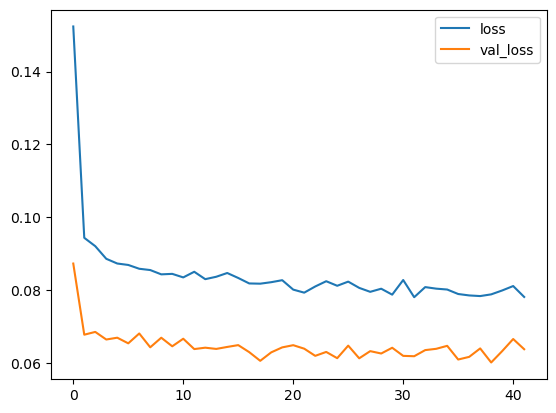

In [53]:
plt.plot(results_mlp.history['loss'], label='loss')
plt.plot(results_mlp.history['val_loss'], label='val_loss')
plt.legend()

In [54]:
# predict next 28 days
horizon = 28
y_preds_mlp = autoregressive_iterative_forecast(model_mlp, X_test[0],
                                                h=horizon)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

It is not always clear how many hidden layers or number of neurons to use in each layer of a neural network and these models are prone to overfitting. In this case, 1 hidden layer was selected with 5 neurons. Having more hidden layers, more neurons or removing dropout was shown to significantly increase the computational time, made validation loss more unstable or was overfit (see additional provided Notebook). However, changing these parameters can highly impact on the model’s predictive performance.

<a id="section4"></a>
## 4. Results

### 4.1 Comparison of Models to Naive Average Model

Each models' performance is checked against the naive Average model using cross-validation of the MAE. The minimum training size was chosen as 366 days, ensuring at least a year's worth of data is included in the train set. This is especially recommended for the Prophet model so it can assess the seasonal trends. The size of the training set is increased by 28 days each time for computation efficiency.

#### 4.1.1 ARIMA Model

In [55]:
# Set minimum training size to encompass a year
min_train_size = 366

# Cross-validation error metrics of ARIMA model
# Uses a 28-day horizon to validate predictions
cv = RollingForecastCV(h=28, step=28, initial=min_train_size)
arima_maes = cross_val_score(arima_model, train, cv=cv, verbose=0,
                             scoring='mean_absolute_error')
arima_mae = arima_maes.mean()
print(f'ARIMA Model MAE: {arima_mae:.2f}')

# Compare to the average model using the same initial train size and step
av = Average()
cv = rolling_forecast_origin(train=train,
                             min_train_size=min_train_size,
                             horizon=28, step=28)
av_maes = cross_validation_score(model=av, cv=cv,
                                metric=mean_absolute_error,
                                n_jobs=-1)
av_mae = av_maes.mean()
print(f'Naive Average Model MAE: {av_mae:.2f}')

ARIMA Model MAE: 8.39
Naive Average Model MAE: 7.59


The ARIMA model has a higher MAE value than the Average model, meaning it was outperformed by the naive model. It has been reported that a seasonal ARIMA model performs well on yearly and monthly data but is less effective at handling weekly or daily data, due to the complexity of multiple seasonal patterns and daily calendar effects (Elseidi, 2023b).

#### 4.1.2 Prophet Model

In [56]:
# Cross-validation error metrics of Prophet model
df_cv = cross_validation(model=prophet_model, initial='366 days',
                         period='28 days', horizon='28 days')

  0%|          | 0/23 [00:00<?, ?it/s]

In [57]:
df_p = performance_metrics(df_cv, rolling_window=28)
df_p

horizon        mse      rmse       mae     mape     mdape     smape  \
0 28 days  63.468012  7.966681  6.332577  0.13144  0.108796  0.128077   

   coverage  
0  0.908385

In [58]:
# Compare to the average and ARIMA models
prophet_mae = df_p.iloc[0,3]
print(f'Prophet Model MAE: {prophet_mae:.2f}')
print(f'ARIMA Model MAE: {arima_mae:.2f}')
print(f'Naive Average Model MAE: {av_mae:.2f}')

Prophet Model MAE: 6.33
ARIMA Model MAE: 8.39
Naive Average Model MAE: 7.59


#### 4.1.3 Regression with ARIMA Errors

In [59]:
# Cross-validation error metrics of regression with ARIMA errors
min_train_size = 366

cv = RollingForecastCV(h=28, step=28, initial=min_train_size)
reg_arima_maes = cross_val_score(reg_arima_err_model, train, cv=cv, verbose=0,
                                 X=reg_exog, scoring='mean_absolute_error')
reg_arima_mae = reg_arima_maes.mean()

print(f'Regression with ARIMA Errors Model MAE: {reg_arima_mae:.2f}')
print(f'Prophet Model MAE: {prophet_mae:.2f}')
print(f'ARIMA Model MAE: {arima_mae:.2f}')
print(f'Naive Average Model MAE: {av_mae:.2f}')

Regression with ARIMA Errors Model MAE: 7.84
Prophet Model MAE: 6.33
ARIMA Model MAE: 8.39
Naive Average Model MAE: 7.59


#### 4.1.4 Feedforward Neural Network

To validate the results of the feedforward neural network, an ensemble method with 20 models was chosen. The median prediction is taken as the forecast with prediction intervals taken as the percentiles.

In [60]:
tf.keras.utils.set_random_seed(1234)

n_models = 20
n_epochs = 100
window_size = 28

es = EarlyStopping(monitor='loss', patience=5)

dropout = False
drop_rate = 0.2

mlp_models = []
# Creates specified number of models and fits to the data
for n in range(n_models):
    model_n = get_network_model(window_size, include_drop_out=dropout,
                                drop_out_rate=drop_rate,
                                metrics=['mse'])

    history = model_n.fit(x=X_train,
                          y=y_train,
                          epochs=n_epochs,
                          verbose=0,
                          callbacks=[es],
                          batch_size=32)

    mlp_models.append(model_n)

In [61]:
horizon = 28
e_mlp_preds = []
# Generates predictions for each of the models
for model in mlp_models:
    y_preds = autoregressive_iterative_forecast(model, X_test[0], h=horizon)
    e_mlp_preds.append(y_preds)

In [62]:
e_mlp_preds = np.asarray(e_mlp_preds)
e_mlp_preds_tran = scaler.inverse_transform(e_mlp_preds).T

# Uses median as the average forecast
y_preds_mlp_mdn = np.percentile(e_mlp_preds_tran.T, 50, axis=0)
# Percentiles are the prediction intervals
y_preds_mlp_2_5 = np.percentile(e_mlp_preds_tran.T, 2.5, axis=0)
y_preds_mlp_97_5 = np.percentile(e_mlp_preds_tran.T, 97.5, axis=0)
y_preds_mlp_10 = np.percentile(e_mlp_preds_tran.T, 10, axis=0)
y_preds_mlp_90 = np.percentile(e_mlp_preds_tran.T, 90, axis=0)
y_preds_mlp_mdn.shape

(28,)

In [63]:
mae_mlp = meanabs(scaler.inverse_transform(y_test), y_preds_mlp)[0]
mae_mlp_mdn = meanabs(scaler.inverse_transform(y_test.T)[0], y_preds_mlp_mdn)

print(f'MLP MAE: {mae_mlp:.2f}')
print(f'MLP Ensemble MAE: {mae_mlp_mdn:.2f}')
print(f'Regression with ARIMA Errors Model MAE: {reg_arima_mae:.2f}')
print(f'Prophet Model MAE: {prophet_mae:.2f}')
print(f'ARIMA Model MAE: {arima_mae:.2f}')
print(f'Naive Average Model MAE: {av_mae:.2f}')

MLP MAE: 6.97
MLP Ensemble MAE: 7.04
Regression with ARIMA Errors Model MAE: 7.84
Prophet Model MAE: 6.33
ARIMA Model MAE: 8.39
Naive Average Model MAE: 7.59


### 4.2 Visual Comparison of Forecast to Test Data

Each model’s forecast of the last 28 days in the data set have been plotted against the actual data, along with their prediction intervals. Winkler score is used to assess the prediction intervals, which is the width of the prediction interval with a penalty, proportional to how far outside the interval if observations lie outside this range. A lower score indicates a model that better encapsulates the test data (Rostami-Tabar and Rendon-Sanchez, 2021).

#### 4.2.1 Average Model

In [64]:
def preds_as_series(data, preds):
    '''
    Converts a numpy array of predictions to a
    pandas.DataFrame with datetimeindex.

    Parameters:
    -----------
    data: pd.DataFrame
        Provides the datatime index to add to the predictions.
    preds: numpy.array
        Predictions from model.

    Returns:
    --------
    preds: pd.DataFrame
        Predictions now with datetime index.
    '''
    start = pd.date_range(start=data.index.max(), periods=2,
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)

    return pd.DataFrame(preds, index=idx)

In [65]:
def plot_prediction_intervals(train, mean, pi1, pi2, test=None,
                              pi_labels=['80% PI', '95% PI']):
    '''
    Plots training data, test data (if required), predictions and 2 sets of
    prediction intervals.

    Parameters:
    -----------
    train: pd.DataFrame
        Training data.
    preds: numpy.array
        Predictions from model.
    intervals: numpy.array
        Prediction intervals of predictions.
    test: pd.DataFrame or None, optional (default = None)
        Test data.
    pi_labels: list, optional (default = ['80% PI', '95% PI'])
        Confidence interval labels.

    Returns:
    --------
    Plot of predictions and confidence intervals.
    '''
    ax = train.plot(figsize=(12,4))

    mean.plot(ax=ax, label='Forecast')

    # Fills in the prediction intervals
    # 80% prediction interval
    ax.fill_between(pi1.index, mean[0], pi1[1],
                    alpha=0.2, label=pi_labels[0], color='yellow');
    ax.fill_between(pi1.index,mean[0], pi1[0],
                    alpha=0.2, label='_none', color='yellow');
    # 95% prediction interval
    ax.fill_between(pi1.index, pi1[1], pi2[1],
                    alpha=0.2, label=pi_labels[1], color='purple');
    ax.fill_between(pi1.index, pi1[0], pi2[0],
                    alpha=0.2, label='_none', color='purple');

    # Plots test data if required and provides legend
    if test is None:
        plt.legend(['Train', 'Forecast', pi_labels[0], '_none', '_none',
                   pi_labels[1]], loc='lower left')
    else:
        test.plot(ax=ax, color='black')
        plt.legend(['Train', 'Forecast', pi_labels[0], '_none', '_none',
                    pi_labels[1], 'Test'], loc='lower left')

In [66]:
# Fits model and makes predictions for the test set
av_model = Average()
av_model.fit(train)
preds, intervals = av_model.predict(horizon=28, return_predict_int=True,
                                    alpha=[0.2, 0.05])

# Converts predictions and intervals to pd.DataFrame
av_mean = preds_as_series(train, preds)
av_pi1 = preds_as_series(train, intervals[0])
av_pi2 = preds_as_series(train, intervals[1])

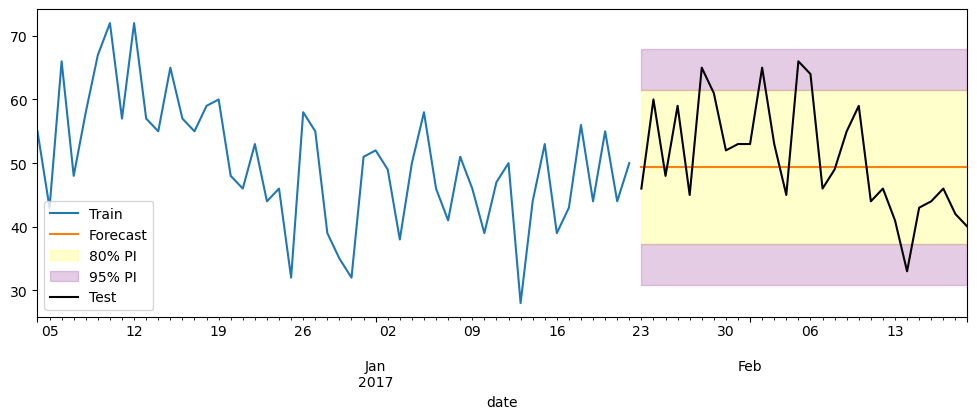

In [67]:
# Plots some of the training data along with the model prediction, test data
# and prediction intervals
# Plot only the last 50 days of the training data to make it easier to see the
# forecast performance
plot_prediction_intervals(train[-50:], av_mean, av_pi1, av_pi2, test=test)

In [68]:
# Winkler score for 80% prediction interval
av_80_ws = winkler_score(intervals[0], test, alpha=0.2)
print(f'Winkler score (80% PI): {av_80_ws:.2f}')

# Winkler score for 95% prediction interval
av_95_ws = winkler_score(intervals[1], test, alpha=0.05)
print(f'Winkler score (95% PI): {av_95_ws:.2f}')

Winkler score (80% PI): 30.76
Winkler score (95% PI): 37.22


In [69]:
def mean_cv_winkler_score(ws_all, pi_str='80'):
    '''
    Finds the mean Winkler score from cross-validation.

    Parameters:
    -----------
    ws_all: list
        List of Winkler scores from cross-validation.
    pi_str: str, optional (default=80)
        Prediction interval size.

    Returns:
    --------
    cv_ws_all: float
        Winkler score.
    '''
    # Finds the mean of all Winkler scores in the list
    cv_ws_all = sum(ws_all) / len(ws_all)
    # Prints out information
    print(f'Winkler score ({pi_str}% PI): {cv_ws_all:.2f}')

    return cv_ws_all

In [70]:
min_train_size = 366
av_80_ws_all = []
av_95_ws_all = []
# Cross-validation of the Winkler score using different test/train splits
cv = rolling_forecast_origin(train=train,
                             min_train_size=min_train_size,
                             horizon=28, step=28)

for split_train, split_test in cv:
    av_model = Average()
    av_model.fit(split_train)
    p, int = av_model.predict(horizon=28, return_predict_int=True,
                              alpha=[0.2, 0.05])

    # Finds Winkler score for each split
    av_80_ws_all.append(winkler_score(int[0], split_test, alpha=0.2))
    av_95_ws_all.append(winkler_score(int[1], split_test, alpha=0.05))

cv_av_80_ws = mean_cv_winkler_score(av_80_ws_all)
cv_av_95_ws = mean_cv_winkler_score(av_95_ws_all, pi_str='95')

Winkler score (80% PI): 34.31
Winkler score (95% PI): 45.79


#### 4.2.2 ARIMA Model

In [71]:
def arima_preds_to_dataframe(y_train, preds, intervals):
    '''
    This function converts pdmarima.ARIMA forecasts into DataFrames with a
    DateTimeIndex.

    Parameters:
    -----------
    y_train: pd.DataFrame
        Training data
    preds: np.array
        Point forecasts.
    intervals: np.array
        Forecast prediction intervals.

    Returns:
    --------
    preds: pd.DataFrame
        Point forecasts.
    intervals: pd.DataFrame
        Forecast prediction intervals.

    '''
    # Prediction begins at the end of the training set
    pred_idx = pd.date_range(start=y_train.index[-1], periods=len(preds)+1,
                             freq=y_train.index.freq)[1:]

    # Creates new DataFrame with DateTimeIndex
    preds = pd.DataFrame(preds, index=pred_idx)
    preds.columns = [0]
    intervals = pd.DataFrame(intervals, index=pred_idx)
    intervals.columns = [0, 1]

    return preds, intervals

In [72]:
# 80% PI
preds, intervals = arima_model.predict(n_periods=28, alpha=0.2,
                                       return_conf_int=True)
arima_mean, arima_pi1 = arima_preds_to_dataframe(train, preds, intervals)

# 95% PI
preds2, intervals2 = arima_model.predict(n_periods=28, alpha=0.05,
                                         return_conf_int=True)
arima_mean, arima_pi2 = arima_preds_to_dataframe(train, preds2, intervals2)

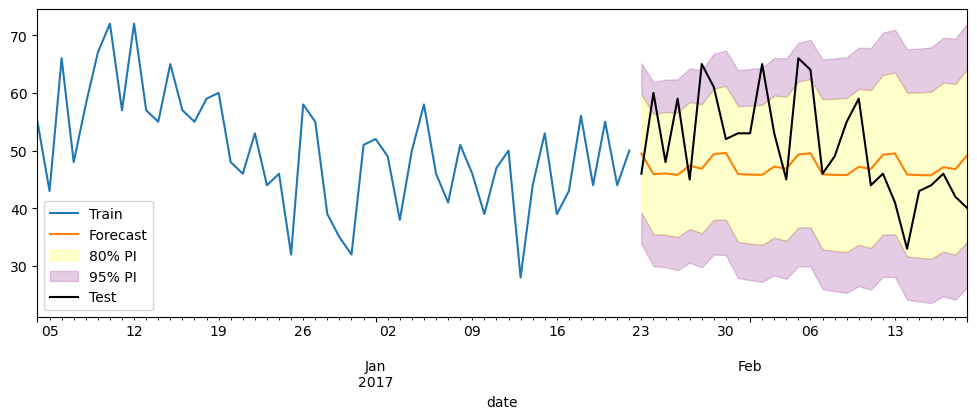

In [73]:
plot_prediction_intervals(train[-50:], arima_mean, arima_pi1, arima_pi2,
                          test=test, pi_labels=['80% PI', '95% PI'])

In [74]:
def winkler_from_pi(prediction_interval, test, alpha=0.2, to_print=False):
    '''
    Finds the Winkler score from prediction intervals stored in a pd.DataFrame
    with a DateTimeIndex.

    Parameters:
    -----------
    prediction_interval: pd.DataFrame
        Prediction intervals from the model, with DateTimeIndex, lower bound
        and upper bound.
    test: pd.DataFrame
        Test data.
    alpha: float, optional (default=0.2)
        Significance level.
    to_print: bool, optional (default=False)
        If Winkler score should be printed.

    Returns:
    --------
    ws: float
        Winkler score.
    '''
    # Removes the DateTimeIndex
    intervals = prediction_interval.reset_index(drop=True)
    # Converts intervals to list of lists containing upper and lower bound
    # Then calculates Winkler score using the test set
    ws = winkler_score(intervals.to_numpy(), test, alpha=alpha)

    # Prints results if required
    if to_print:
        pi_str = str((100 - (alpha*100)))
        print(f'Winkler score ({pi_str}% PI): {ws:.2f}')

    return ws

In [75]:
# Winkler score for 80% prediction interval
arima_80_ws = winkler_from_pi(arima_pi1, test, to_print=True)
# Winkler score for 95% prediction interval
arima_95_ws = winkler_from_pi(arima_pi2, test, alpha=0.05, to_print=True)

Winkler score (80.0% PI): 34.63
Winkler score (95.0% PI): 41.20


In [76]:
def cv_arima_winkler_score(split_train, split_test, n_periods=28, alpha=0.2):
    '''
    Finds the Winkler score from an ARIMA model to be used for
    cross-validation.

    Parameters:
    -----------
    split_train: list
        Training data.
    split_test: list
        Test data.
    n_periods: int, optional (default=28)
        Horizon to predict.
    alpha: float, optional (default=0.2)
        Significance level.

    Returns:
    --------
    ws: float
        Winkler score.
    '''
    arima_model = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 2, 7),
                        suppress_warnings=True)
    arima_model.fit(split_train)

    pred, int = arima_model.predict(n_periods=n_periods, alpha=alpha,
                                    return_conf_int=True)
    pred, int = arima_preds_to_dataframe(split_train, pred, int)

    ws = winkler_from_pi(int, split_test, alpha=alpha)

    return ws

In [77]:
min_train_size = 366
arima_80_ws_all = []
arima_95_ws_all = []
# Cross-validation of Winkler score using different test/train splits
cv = rolling_forecast_origin(train=train,
                             min_train_size=min_train_size,
                             horizon=28, step=28)

for split_train, split_test in cv:
    arima_80_ws_all.append(cv_arima_winkler_score(split_train, split_test))

    arima_95_ws_all.append(cv_arima_winkler_score(split_train, split_test,
                                                  alpha=0.05))

# Finds the mean of all the scores
cv_arima_80_ws = mean_cv_winkler_score(arima_80_ws_all)
cv_arima_95_ws = mean_cv_winkler_score(arima_95_ws_all, pi_str='95')

Winkler score (80% PI): 37.03
Winkler score (95% PI): 50.04


#### 4.2.3 Prophet Model

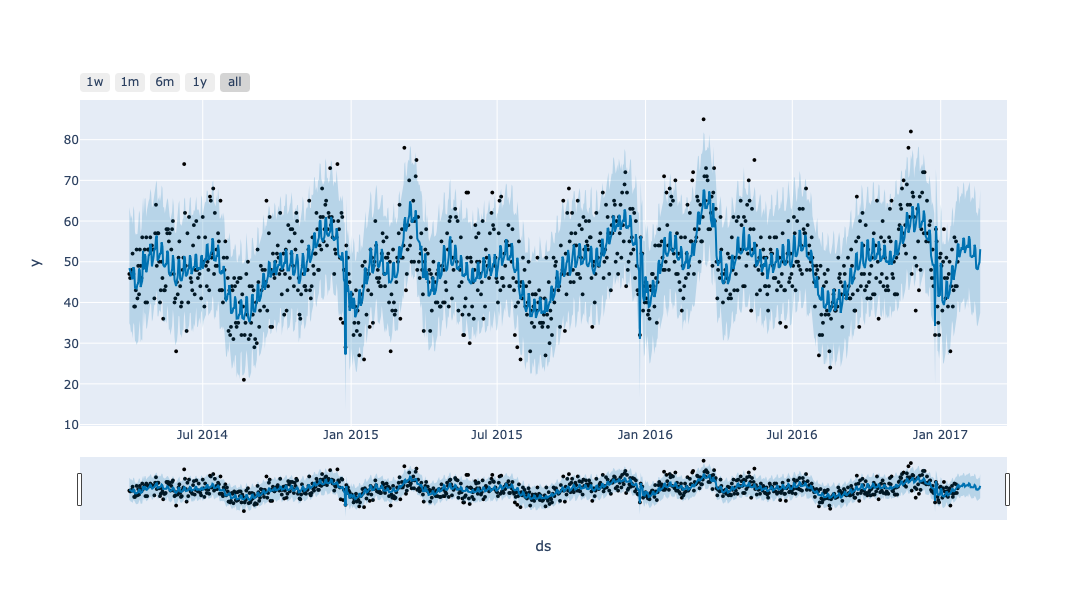

In [78]:
plot_plotly(prophet_model, prophet_forecast)

The components of the model are plotted below. The first plot shows the general trend, the second plot shows how holidays impact the predictions, e.g. Christmas day shows a large decrease in attendances and the third plot gives the January monthly trend. The fourth plot shows the yearly trend, with lowest attendances in August/September and the highest occurring around March and December. The last plot shows the impact of the day of the week.

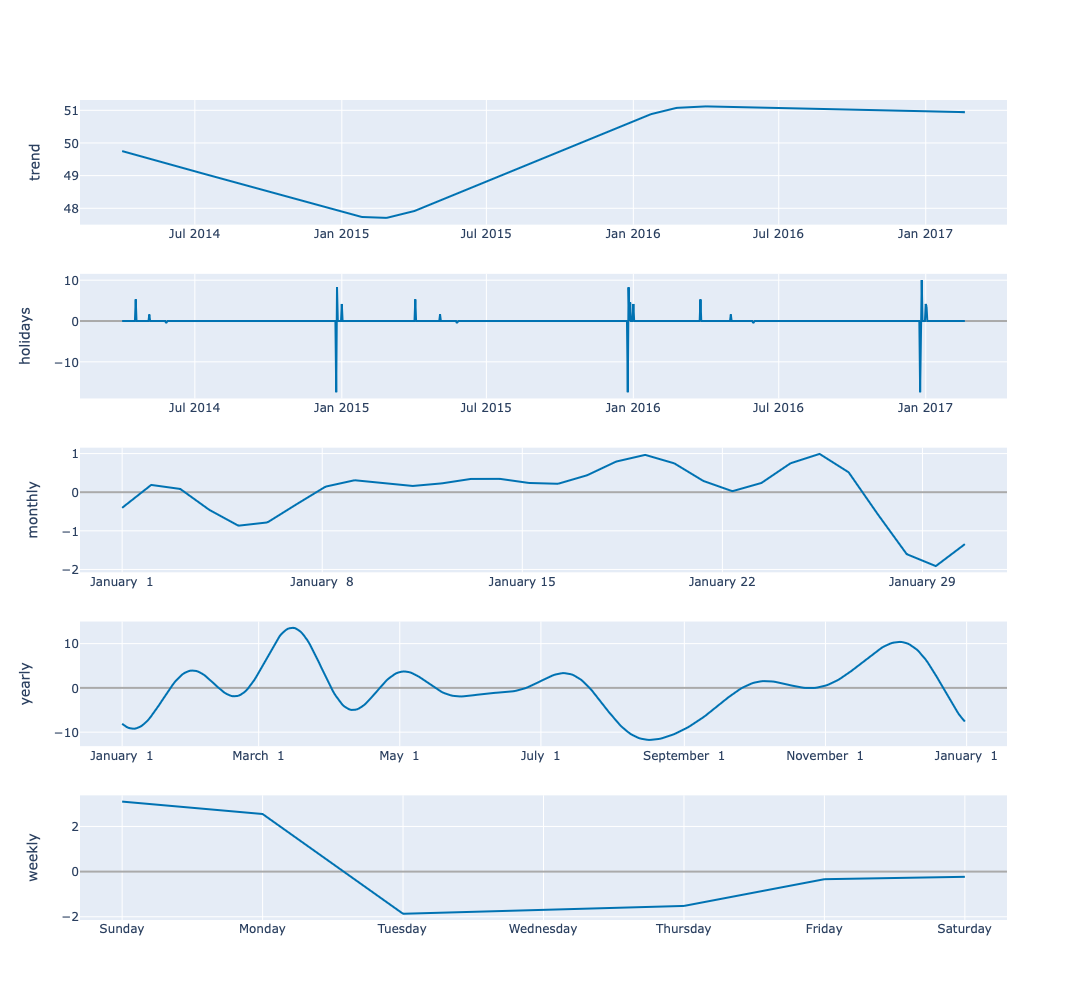

In [79]:
plot_components_plotly(prophet_model, prophet_forecast)

In [80]:
# 80% prediction interval forecast
prophet_model = make_prophet_model(interval=0.8)
prophet_forecast = create_prophet_forecast(prophet_model, train)

In [81]:
# 95% prediction interval forecast
prophet_model2 = make_prophet_model(interval=0.95)
prophet_forecast2 = create_prophet_forecast(prophet_model2, train)

In [82]:
def prophet_forecast_to_plot(prophet_forecast, train):
    '''
    Finds point forecast using output from Prophet model and converts to a
    suitable format for plotting.

    Parameters:
    -----------
    prophet_forecast: pd.DataFrame
        Output from Prophet model prediction.
    train: pd.DataFrame
        Training data.

    Returns:
    --------
    prophet_mean: pd.DataFrame
        Point forecast from Prophet model.
    '''
    # Column containing point forecast
    prophet_preds = prophet_forecast.loc[:,'yhat']
    prophet_preds = prophet_preds.to_numpy()
    # Convert predictions in suitable format for plotting
    prophet_mean = preds_as_series(train, prophet_preds[-28:])

    return prophet_mean

In [83]:
prophet_mean = prophet_forecast_to_plot(prophet_forecast, train)

In [84]:
def pred_intervals_to_plot(prophet_forecast, train):
    '''
    Finds prediction intervals using output from Prophet model and converts to
    a suitable format for plotting.

    Parameters:
    -----------
    prophet_forecast: pd.DataFrame
        Output from Prophet model prediction.
    train: pd.DataFrame
        Training data.

    Returns:
    --------
    prophet_pi: pd.DataFrame
        Prediction intervals from Prophet model.
    '''
    # Columns containing prediction interval
    prophet_upi = prophet_forecast.loc[:,'yhat_upper']
    prophet_lpi = prophet_forecast.loc[:,'yhat_lower']

    # Creates list of lists containing upper and lower bound
    prophet_int = []
    for upi, lpi in zip(prophet_upi, prophet_lpi):
        ints = [lpi, upi]
        prophet_int.append(ints)

    # Converts to a suitable format for plotting
    prophet_int = np.array(prophet_int)
    prophet_pi = preds_as_series(train, prophet_int[-28:])

    return prophet_pi

In [85]:
prophet_pi1 = pred_intervals_to_plot(prophet_forecast, train)
prophet_pi2 = pred_intervals_to_plot(prophet_forecast2, train)

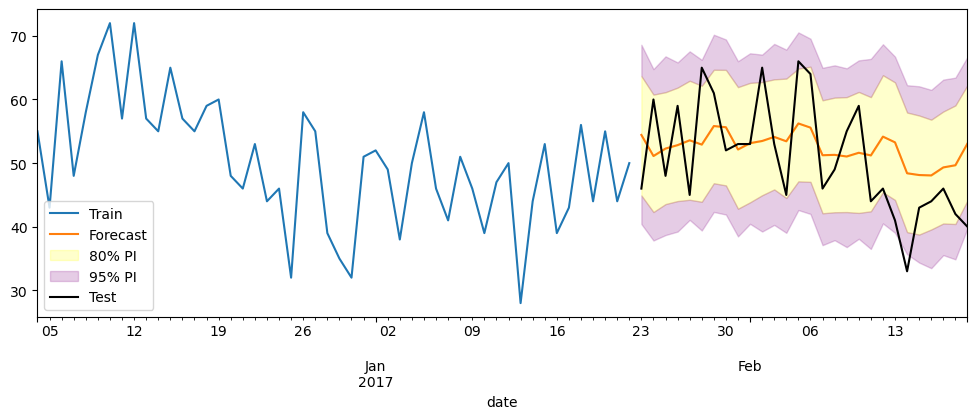

In [86]:
plot_prediction_intervals(train[-50:], prophet_mean, prophet_pi1, prophet_pi2,
                          test=test, pi_labels=['80% PI', '95% PI'])

In [87]:
# Winkler score for 80% prediction interval
prophet_80_ws = winkler_from_pi(prophet_pi1, test, to_print=True)
# Winkler score for 95% prediction interval
prophet_95_ws = winkler_from_pi(prophet_pi2, test, alpha=0.05, to_print=True)

Winkler score (80.0% PI): 25.26
Winkler score (95.0% PI): 31.54


In [88]:
def cv_prophet_winkler_score(split_train, split_test, alpha=0.2):
    '''
    Finds the Winkler score from a Prophet model to be used for
    cross-validation.

    Parameters:
    -----------
    split_train: list
        Training data.
    split_test: list
        Test data.
    alpha: float, optional (default=0.2)
        Significance level.

    Returns:
    --------
    ws: float
        Winkler score.
    '''
    # Creates forecast using Prophet model
    interval = 1 - alpha
    prophet_model = make_prophet_model(interval=interval)
    prophet_forecast = create_prophet_forecast(prophet_model, split_train)

    # Gets prediction intervals in expected format and calculates Winkler score
    int = pred_intervals_to_plot(prophet_forecast, split_train)
    ws = winkler_from_pi(int, split_test, alpha=alpha)

    return ws

In [89]:
min_train_size = 366
prophet_80_ws_all = []
prophet_95_ws_all = []
# Uses cross-validation to get an average Winkler score using cross-validation
cv = rolling_forecast_origin(train=train,
                             min_train_size=min_train_size,
                             horizon=28, step=28)

for split_train, split_test in cv:
    prophet_80_ws_all.append(cv_prophet_winkler_score(split_train, split_test))

    prophet_95_ws_all.append(cv_prophet_winkler_score(split_train, split_test,
                                                      alpha=0.05))

cv_prophet_80_ws = mean_cv_winkler_score(prophet_80_ws_all)
cv_prophet_95_ws = mean_cv_winkler_score(prophet_95_ws_all, pi_str='95')

Winkler score (80% PI): 32.81
Winkler score (95% PI): 42.88


#### 4.2.4 Regression with ARIMA Errors

In [90]:
# 80% Prediction Interval
preds, intervals = reg_arima_err_model.predict(n_periods=28,
                                               X=reg_arima_err_future,
                                               return_conf_int=True,
                                               alpha=0.2)
reg_arima_err_mean, reg_arima_err_pi1 = arima_preds_to_dataframe(train, preds,
                                                                 intervals)

In [91]:
# 95% Prediction Interval
preds2, intervals2 = reg_arima_err_model.predict(n_periods=28,
                                                 X=reg_arima_err_future,
                                                 return_conf_int=True,
                                                 alpha=0.05)
reg_arima_err_mean, reg_arima_err_pi2 = arima_preds_to_dataframe(train,
                                                                 preds2,
                                                                 intervals2)

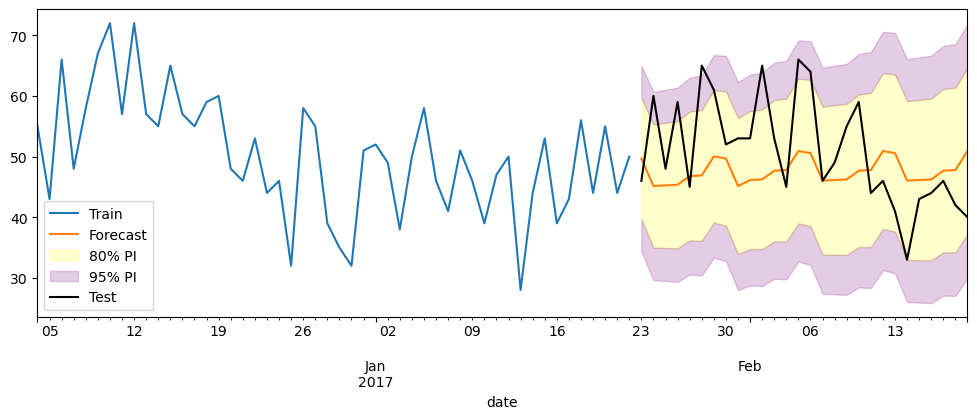

In [92]:
plot_prediction_intervals(train[-50:], reg_arima_err_mean, reg_arima_err_pi1,
                          reg_arima_err_pi2,
                          test=test, pi_labels=['80% PI', '95% PI'])

In [93]:
# Winkler score for 80% prediction interval
reg_arima_err_80_ws = winkler_from_pi(reg_arima_err_pi1, test, to_print=True)
# Winkler score for 95% prediction interval
reg_arima_err_95_ws = winkler_from_pi(reg_arima_err_pi2, test, alpha=0.05,
                                      to_print=True)

Winkler score (80.0% PI): 33.54
Winkler score (95.0% PI): 40.51


#### 4.2.5 Feedforward Neural Network

In [94]:
def plot_prediction(model, X_train, y_train, y_test, y_preds):
    '''
    Plots prediction from NN model against the training and test data.

    Parameters:
    -----------
    model:
        Sequential neural network model.
    X_train: np.ndarray
        Training data.
    y_train: np.ndarray
        Training data.
    y_test: np.ndarray
        Test data.
    y_preds: np.ndarray
        Predicted values.

    Returns:
    --------
    Plot of prediction against actual.

    '''
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    # Adds NAN values up to where predictions/test start or else plots at 0
    padding = np.full(len(fitted_values), np.NAN)
    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

1/1 [==============================] - 0s 27ms/step


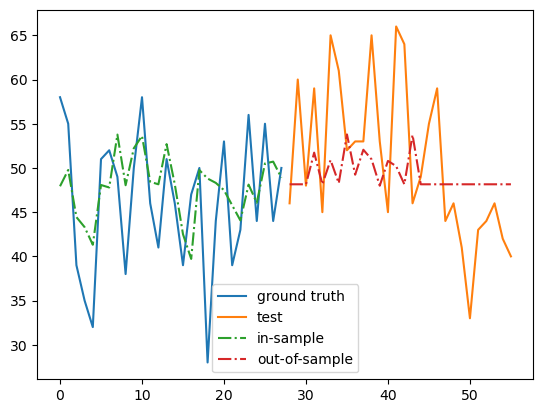

In [95]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

In [96]:
def nn_intervals_to_plot(preds_lower, preds_upper, train):
    '''
    Finds prediction intervals using output from an ensemble of neural network
    models and converts to a suitable format for plotting.

    Parameters:
    -----------
    preds_lower: np.ndarray
        Lower bound from NN ensemble.
    preds_upper: np.ndarray
           Upper bound from NN ensemble.
    train: pd.DataFrame
        Training data.

    Returns:
    --------
    nn_pi: pd.DataFrame
        Prediction intervals from NN model.
    '''
    intervals = []
    for lb, up in zip(preds_lower, preds_upper):
        intervals.append([lb, up])
    intervals = np.array(intervals)
    nn_pi = preds_as_series(train, intervals)

    return nn_pi

In [97]:
# Converts intervals and forecast into suitable format for plotting
nn_pi1 = nn_intervals_to_plot(y_preds_mlp_10, y_preds_mlp_90, train)
nn_pi2 = nn_intervals_to_plot(y_preds_mlp_2_5, y_preds_mlp_97_5, train)
nn_mean = preds_as_series(train, y_preds_mlp_mdn)

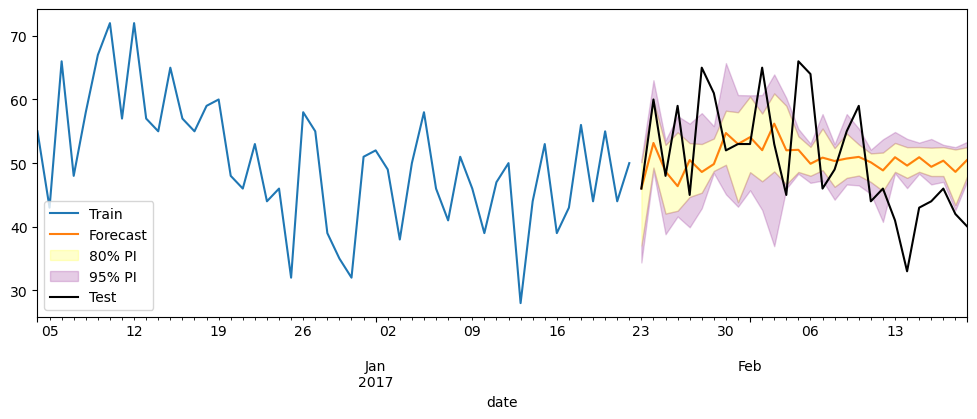

In [98]:
plot_prediction_intervals(train[-50:], nn_mean, nn_pi1, nn_pi2,
                          test=test, pi_labels=['80% PI', '95% PI'])

In [99]:
# Winkler score for 80% prediction interval
nn_80_ws = winkler_from_pi(nn_pi1, test, to_print=True)
# Winkler score for 95% prediction interval
nn_95_ws = winkler_from_pi(nn_pi2, test, alpha=0.05, to_print=True)

Winkler score (80.0% PI): 47.58
Winkler score (95.0% PI): 132.05


#### 4.2.6 Visualising All Models

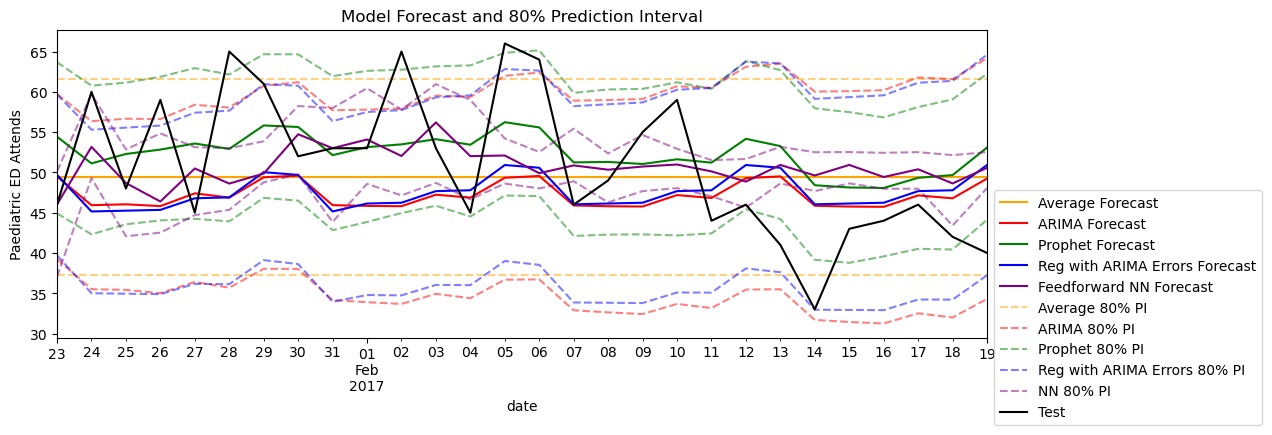

In [100]:
# Plotting the 80% prediction interval and the forecast for the models

# Plots the forecast values
ax = av_mean.plot(figsize=(12,4), label='Average Forecast', color='orange')
arima_mean.plot(ax=ax, label='ARIMA Forecast', color='red')
prophet_mean.plot(ax=ax, label='Prophet Forecast', color='green')
reg_arima_err_mean.plot(ax=ax, label='Reg with ARIMA Errors Forecast',
                        color='blue')
nn_mean.plot(ax=ax, label='Feedforward NN Forecast', color='purple')
# Plots the prediction intervals
av_pi1.plot(ax=ax, linestyle='--', alpha=0.5, color='orange')
arima_pi1.plot(ax=ax, linestyle='--', alpha=0.5, color='red')
prophet_pi1.plot(ax=ax, linestyle='--', alpha=0.5, color='green')
reg_arima_err_pi1.plot(ax=ax, linestyle='--', alpha=0.5, color='blue')
nn_pi1.plot(ax=ax, linestyle='--', alpha=0.5, color='purple')
# Plots the test data
test.plot(ax=ax, color='black')

plt.legend(['Average Forecast', 'ARIMA Forecast',
            'Prophet Forecast', 'Reg with ARIMA Errors Forecast',
            'Feedforward NN Forecast', 'Average 80% PI', '_none',
            'ARIMA 80% PI', '_none', 'Prophet 80% PI', '_none',
            'Reg with ARIMA Errors 80% PI', '_none', 'NN 80% PI', '_none',
            'Test'], bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Paediatric ED Attends')
plt.title('Model Forecast and 80% Prediction Interval')
plt.show()

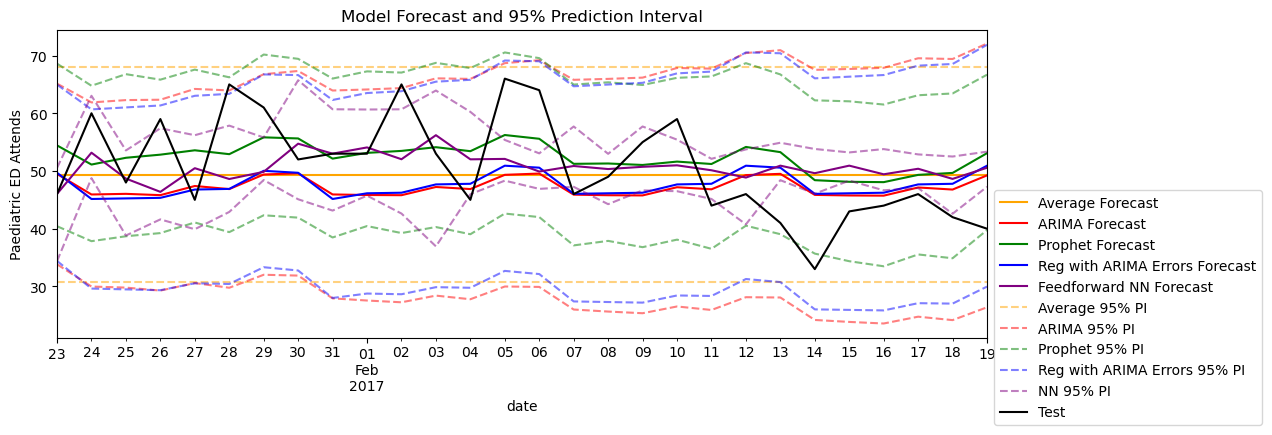

In [101]:
# Plotting the 95% prediction interval and the forecast for the models

# Plots the forecast values
ax = av_mean.plot(figsize=(12,4), label='Average Forecast', color='orange')
arima_mean.plot(ax=ax, label='ARIMA Forecast', color='red')
prophet_mean.plot(ax=ax, label='Prophet Forecast', color='green')
reg_arima_err_mean.plot(ax=ax, label='Reg with ARIMA Errors Forecast',
                        color='blue')
nn_mean.plot(ax=ax, label='Feedforward NN Forecast', color='purple')
# Plots the prediction intervals
av_pi2.plot(ax=ax, linestyle='--', alpha=0.5, color='orange')
arima_pi2.plot(ax=ax, linestyle='--', alpha=0.5, color='red')
prophet_pi2.plot(ax=ax, linestyle='--', alpha=0.5, color='green')
reg_arima_err_pi2.plot(ax=ax, linestyle='--', alpha=0.5, color='blue')
nn_pi2.plot(ax=ax, linestyle='--', alpha=0.5, color='purple')
# Plots the test data
test.plot(ax=ax, color='black')

plt.legend(['Average Forecast', 'ARIMA Forecast',
            'Prophet Forecast', 'Reg with ARIMA Errors Forecast',
            'Feedforward NN Forecast', 'Average 95% PI', '_none',
            'ARIMA 95% PI', '_none', 'Prophet 95% PI', '_none',
            'Reg with ARIMA Errors 95% PI', '_none', 'NN 95% PI', '_none',
            'Test'], bbox_to_anchor=(1.0, 0.5))

plt.ylabel('Paediatric ED Attends')
plt.title('Model Forecast and 95% Prediction Interval')
plt.show()

### 4.3 Choosing the Model

#### 4.3.1 Mean Absolute Error

In [102]:
# Creates table to compare MAE values of the models
mae_table = pd.DataFrame([{'Average':av_mae}])
mae_table['ARIMA'] = arima_mae
mae_table['Prophet'] = prophet_mae
mae_table['Reg ARIMA Errors'] = reg_arima_mae
mae_table['Neural Network'] = mae_mlp
mae_table['NN Ensemble'] = mae_mlp_mdn
print('MAE: ')
mae_table

MAE: 


Average    ARIMA   Prophet  Reg ARIMA Errors  Neural Network  NN Ensemble
0  7.587722  8.38665  6.332577          7.844369        6.965055     7.040922

#### 4.3.2 Winkler Score

In [103]:
# Creates table to compare Winkler Score of the models
ws_table = pd.DataFrame({'PI' : ['80%', '95%'],
                         'Average' : [av_80_ws, av_95_ws]}).set_index(['PI'])
ws_table['ARIMA'] = [arima_80_ws, arima_95_ws]
ws_table['Prophet'] = [prophet_80_ws, prophet_95_ws]
ws_table['Reg ARIMA Errors'] = [reg_arima_err_80_ws, reg_arima_err_95_ws]
ws_table['NN Ensemble'] = [nn_80_ws, nn_95_ws]
print('Winkler Score:')
ws_table

Winkler Score:


Average      ARIMA    Prophet  Reg ARIMA Errors  NN Ensemble
PI                                                                 
80%  30.758231  34.625355  25.257117         33.535267    47.579119
95%  37.215171  41.204939  31.543275         40.512362   132.047761

In [121]:
# Creates table to compare Winkler Score from cross-validation
cv_ws_table = pd.DataFrame({'PI' : ['80%', '95%'],
                           'Average' : [cv_av_80_ws,
                                        cv_av_95_ws]}).set_index(['PI'])
cv_ws_table['ARIMA'] = [cv_arima_80_ws, cv_arima_95_ws]
cv_ws_table['Prophet'] = [cv_prophet_80_ws, cv_prophet_95_ws]
print('Winkler Score Using Cross-Validation:')
cv_ws_table

Winkler Score Using Cross-Validation:


Average      ARIMA    Prophet
PI                                  
80%  34.311226  37.030040  32.806773
95%  45.794362  50.035756  42.878535

The Winkler score was not cross-validated for the regression with ARIMA errors model due to the time taken to fit the model. When considering the error metrics, this model performs less well than the Prophet model so will not be chosen. The neural network model produces very small prediction intervals and has the worst Winkler score, so similarly was not investigated further.

#### 4.3.3 Days Over-Predicted Attendance

In [123]:
def over_under_predicted(test, pred, col=0, over_pred=True):
    '''
    Finds number of days the chosen model has over-predicted or under-
    predicted ED attendance.

    Parameters:
    -----------
    pred:
        Predictions from model.
    test: pd.DataFrame
        Test data.
    col: 0 or 1, optional (default=0)
        Column name to get predictions from (1 if upper bound prediction
        interval, 0 if lower bound or point forecast).
    over_pred: bool, optional (default=True)
        True if want to find number of over-predicted days, False if want
        under-predicted days.

    Returns:
    --------
    count: int
        Number of days over-predicted or under-predicted attendance.
    '''
    count = 0
    test = test['paed_ed_attends'].to_list()
    pred = pred[col].to_list()
    for tst, prd in zip(test, pred):
        if over_pred:
            if float(prd) - float(tst) >= 1:
                count += 1
        else:
            if float(prd) - float(tst) <= 1:
                count += 1

    return count

In [122]:
def find_over_under_pred(test, mean, pi1, pi2, over_pred=True):
    '''
    Finds number of days the chosen model has over-predicted or under-
    predicted ED attendance for the point forecast and prediction intervals
    (assumes 2) and puts into a list to be added to pd.DataFrame.

    Parameters:
    -----------
    test: pd.DataFrame
        Test data.
    mean: pd.DataFrame
        Point forecast.
    pi1: pd.DataFrame
        First prediction interval.
    pi2: pd.DataFrame
        Second prediction interval.
    over_pred: bool, optional (default=True)
        True if want to find number of over-predicted days, False if want
        under-predicted days.

    Returns:
    --------
    days_ou: list
        Number of days over-predicted or under-predicted attendance for the
        point forecast and prediction intervals.
    '''
    mean_ou = over_under_predicted(test, mean, over_pred=over_pred)
    pi1_ou = over_under_predicted(test, pi1, over_pred=over_pred)
    pi1_ou2 = over_under_predicted(test, pi1, col=1, over_pred=over_pred)
    pi2_ou = over_under_predicted(test, pi2, over_pred=over_pred)
    pi2_ou2 = over_under_predicted(test, pi2, col=1, over_pred=over_pred)
    days_ou = [mean_ou, pi1_ou, pi1_ou2, pi2_ou, pi2_ou2]

    return days_ou

In [124]:
av_days_over = find_over_under_pred(test, av_mean, av_pi1, av_pi2)

days_o_table = pd.DataFrame({'Prediction' : ['Forecast', 'Lower 80%',
                                             'Upper 80%', 'Lower 95%',
                                             'Upper 95%'],
                             'Average' : av_days_over})
days_o_table.set_index(['Prediction'], inplace=True)
days_o_table['ARIMA'] = find_over_under_pred(test, arima_mean, arima_pi1,
                                             arima_pi2)
days_o_table['Prophet'] = find_over_under_pred(test, prophet_mean, prophet_pi1,
                                               prophet_pi2)
days_o_table['Reg ARIMA Errors'] = find_over_under_pred(test,
                                                        reg_arima_err_mean,
                                                        reg_arima_err_pi1,
                                                        reg_arima_err_pi2)
days_o_table['NN Ensemble'] = find_over_under_pred(test, nn_mean, nn_pi1,
                                                   nn_pi2)
print('Days Over-Predicted Attendance: ')
days_o_table

Days Over-Predicted Attendance: 


Average  ARIMA  Prophet  Reg ARIMA Errors  NN Ensemble
Prediction                                                        
Forecast         14     12       17                12           16
Lower 80%         1      0        3                 0           10
Upper 80%        23     21       24                21           19
Lower 95%         0      0        1                 0            8
Upper 95%        28     26       28                25           21

#### 4.3.4 Days Under-Predicted Attendance

In [125]:
av_days_under = find_over_under_pred(test, av_mean, av_pi1, av_pi2,
                                     over_pred=False)

days_u_table = pd.DataFrame({'Prediction' : ['Forecast', 'Lower 80%',
                                             'Upper 80%', 'Lower 95%',
                                             'Upper 95%'],
                            'Average' : av_days_under})
days_u_table.set_index(['Prediction'], inplace=True)
days_u_table['ARIMA'] = find_over_under_pred(test, arima_mean, arima_pi1,
                                             arima_pi2, over_pred=False)
days_u_table['Prophet'] = find_over_under_pred(test, prophet_mean, prophet_pi1,
                                               prophet_pi2, over_pred=False)
days_u_table['Reg ARIMA Errors'] = find_over_under_pred(test,
                                                        reg_arima_err_mean,
                                                        reg_arima_err_pi1,
                                                        reg_arima_err_pi2,
                                                        over_pred=False)
days_u_table['NN Ensemble'] = find_over_under_pred(test, nn_mean, nn_pi1,
                                                   nn_pi2, over_pred=False)
print('Days Under-Predicted Attendance: ')
days_u_table

Days Under-Predicted Attendance: 


Average  ARIMA  Prophet  Reg ARIMA Errors  NN Ensemble
Prediction                                                        
Forecast         14     16       11                16           12
Lower 80%        27     28       25                28           18
Upper 80%         5      7        4                 7            9
Lower 95%        28     28       27                28           20
Upper 95%         0      2        0                 3            7

#### 4.3.5 Chosen Model

Therefore, the model most suited for predicting ED attendances over the next 28 days is the Prophet model. It gave the lowest MAE and was more accurate by approximately 1.5 attendances a day compared to the Average model. The Prophet model has the lowest Winkler scores, meaning the prediction intervals are smaller and the prediction more precise.

The Prophet model forecast showed similar trends to the test data. The 95% prediction interval captures the highest spikes in attendances, and the 80% prediction interval also performs well, with the majority of points not being underpredicted. To inform staffing decisions, it is important not to underpredict the number of patients, as this would put pressure on available staff and potentially put patients' lives at risk. There was one day where the prediction intervals failed to capture the drop in attendance. Greatly overestimating attendances has the potential to be more costly in terms of staffing decisions, but does not risk the safety of patients. However, the predictions are never as high or low as they were in reality and the actual values lie outside the prediction interval range towards the end of the prediction interval. There are some points where the prediction has the opposite trend to the test data, e.g. at the end of the forecast.

### 4.4 Predicting Paediatric ED Attendances for the next 28-day period

In [109]:
# 80% prediction interval forecast for next 28 days
prophet_model_unseen = make_prophet_model(interval=0.8)
prophet_forecast_unseen = create_prophet_forecast(prophet_model_unseen,
                                                  attends)

# 95% prediction interval forecast for next 28 days
prophet_model_unseen2 = make_prophet_model(interval=0.95)
prophet_forecast_unseen2 = create_prophet_forecast(prophet_model_unseen2,
                                                   attends)

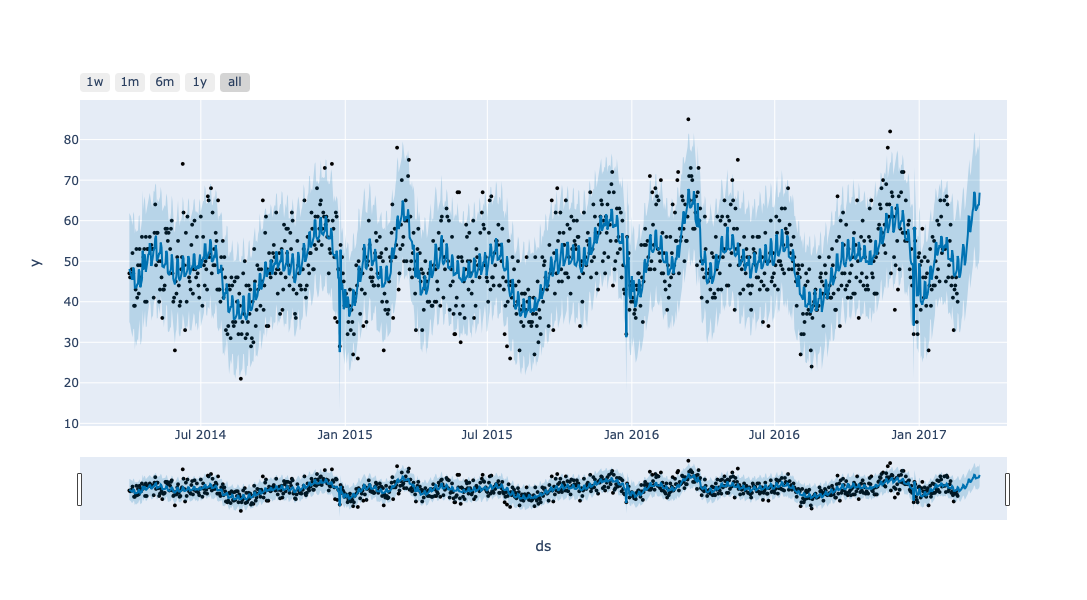

In [110]:
plot_plotly(prophet_model_unseen2, prophet_forecast_unseen2)

In [111]:
# Puts prediction and prediction intervals into a suitable format to plot
prophet_mean_unseen = prophet_forecast_to_plot(prophet_forecast_unseen,
                                               attends)
prophet_pi1_unseen = pred_intervals_to_plot(prophet_forecast_unseen, attends)
prophet_pi2_unseen = pred_intervals_to_plot(prophet_forecast_unseen2, attends)

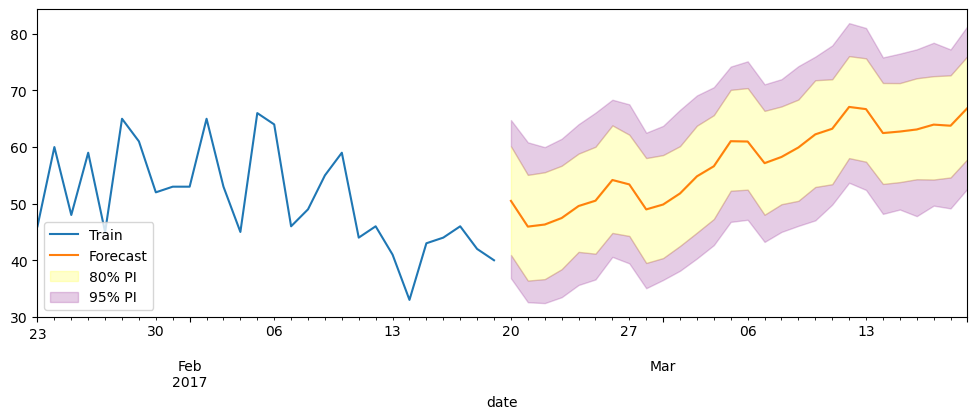

In [112]:
plot_prediction_intervals(attends[-28:], prophet_mean_unseen,
                          prophet_pi1_unseen, prophet_pi2_unseen,
                          pi_labels=['80% PI', '95% PI'])

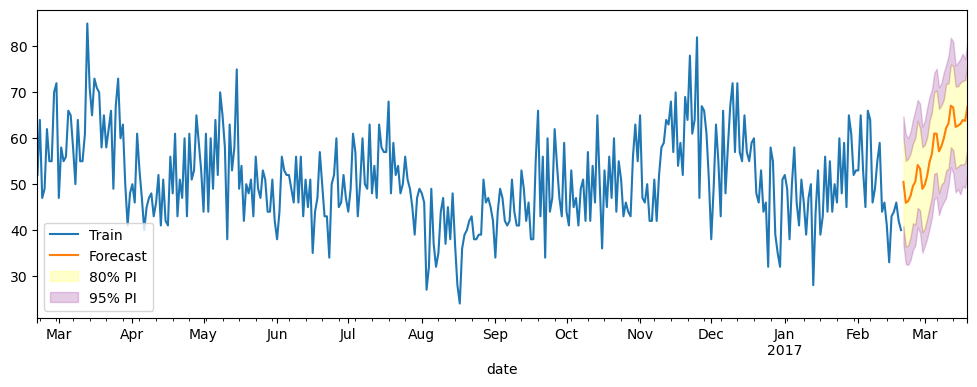

In [113]:
# Plot a year's worth of data and the forecast for reference
plot_prediction_intervals(attends[-365:], prophet_mean_unseen,
                          prophet_pi1_unseen, prophet_pi2_unseen,
                          pi_labels=['80% PI', '95% PI'])

In [114]:
def prophet_bounds(prophet_forecast, upper=True):
    '''
    Finds upper or lower bounds of Prophet forecast from model output.

    Parameters:
    -----------
    prophet_forecast: pd.DataFrame
        Output forecast from Prophet model.
    upper: bool, optional (default=True)
        True if want upper bound, False if lower bound.

    Returns:
    --------
    pred_bound: list
        Upper or lower bound from Prophet forecast.
    '''
    # Finds relevant column from forecast
    if upper:
        prophet_bound = prophet_forecast.loc[:,'yhat_upper']
    else:
        prophet_bound = prophet_forecast.loc[:,'yhat_lower']

    # Converts to list
    pred_bound = list(prophet_bound[-28:].round(0))

    return pred_bound

In [126]:
# Puts point forecast and prediction interval predictions of paediatric ED
# attendances over the next 28 days in a pd.DataFrame
start = pd.date_range(start=attends.index.max(), periods=2,
                      freq=attends.index.freq).max()
idx = pd.date_range(start=start, periods=28, freq=attends.index.freq)
forecast_preds = prophet_mean_unseen.round(0).stack().tolist()
forecast = pd.DataFrame(forecast_preds, columns=['Point Forecast'],
                        index=idx)
forecast['Upper 80%'] = prophet_bounds(prophet_forecast_unseen)
forecast['Lower 80%'] = prophet_bounds(prophet_forecast_unseen, upper=False)
forecast['Upper 95%'] = prophet_bounds(prophet_forecast_unseen2)
forecast['Lower 95%'] = prophet_bounds(prophet_forecast_unseen2, upper=False)

forecast

Point Forecast  Upper 80%  Lower 80%  Upper 95%  Lower 95%
2017-02-20            50.0       60.0       41.0       65.0       37.0
2017-02-21            46.0       55.0       36.0       61.0       33.0
2017-02-22            46.0       56.0       37.0       60.0       32.0
2017-02-23            47.0       57.0       38.0       61.0       33.0
2017-02-24            50.0       59.0       41.0       64.0       36.0
2017-02-25            51.0       60.0       41.0       66.0       37.0
2017-02-26            54.0       64.0       45.0       68.0       41.0
2017-02-27            53.0       62.0       44.0       68.0       39.0
2017-02-28            49.0       58.0       40.0       63.0       35.0
2017-03-01            50.0       59.0       40.0       64.0       37.0
2017-03-02            52.0       60.0       43.0       67.0       38.0
2017-03-03            55.0       64.0       45.0       69.0       40.0
2017-03-04            57.0       66.0       47.0       71.0       43.0
2017-03-05            61.0       70.0       52.0       74.0       47.0
2017-03-06            61.0       70.0       52.0       75.0       47.0
2017-03-07            57.0       66.0       48.0       71.0       43.0
2017-03-08            58.0       67.0       50.0       72.0       45.0
2017-03-09            60.0       68.0       51.0       74.0       46.0
2017-03-10            62.0       72.0       53.0       76.0       47.0
2017-03-11            63.0       72.0       53.0       78.0       50.0
2017-03-12            67.0       76.0       58.0       82.0       54.0
2017-03-13            67.0       76.0       57.0       81.0       52.0
2017-03-14            62.0       71.0       53.0       76.0       48.0
2017-03-15            63.0       71.0       54.0       77.0       49.0
2017-03-16            63.0       72.0       54.0       77.0       48.0
2017-03-17            64.0       73.0       54.0       78.0       50.0
2017-03-18            64.0       73.0       55.0       77.0       49.0
2017-03-19            67.0       76.0       58.0       81.0       53.0

In [127]:
print(f'Minimum point forecast daily attendance: {min(forecast_preds)}')
print(f'Maximum point forecast daily attendance: {max(forecast_preds)}')

Minimum point forecast daily attendance: 46.0
Maximum point forecast daily attendance: 67.0


In [117]:
# Difference on average between point forecast and upper 95% PI, which
# captured all the test data
high_pred_diff = np.asarray(prophet_bounds(prophet_forecast_unseen2)) - \
                     np.asarray(forecast_preds)
print(f'Upper 95% - Point Forecast Average: {high_pred_diff.mean().round(0)}')

Upper 95% - Point Forecast Average: 14.0


<a id="section5"></a>
## 5. Discussion

### 5.1 Model Forecast and Staffing Recommendations

The Prophet model was chosen as the most suitable for predicting daily paediatric ED attendances because it showed the best performance when predicting a 28-day horizon by comparing the MAE, Winkler score and the number of days under- and over-predicting attendance. This model was then provided with the full data set of ED attendances and used to forecast the next 28 days, as shown above. The forecast predicted a general increase in the number of attendances from 20th February to 19th March. The lowest number of forecast attendances was 46, occurring in the first few days of the forecast, compared to the highest at 67 towards the end. 

However, the point forecast under-predicted the attendance in many of the days in the test set. Therefore, in order to be more confident that there will not be more attendances than forecast, the upper prediction interval (PI) could be taken as the forecast. In predicting the test set, the point forecast underestimated 39% of the time, the 80% PI underestimated 14% of the time, while the 95% prediction interval did not underestimate. The 95% PI suggests the lowest number of attendances will be 60 and the highest 82. However, this is likely to be an over-estimation on most days. On average, the upper 95% PI predicts attendance to be 14 people higher than the point forecast. Therefore, any staffing decisions made will have to consider the effect of over-staffing against under-staffing when deciding which forecast to use. Decisions could involve having staff members on-call in case of an under-prediction, which is potentially less costly than having too many staff members in work.

### 5.2 Limitations

However, there are some limitations in the chosen model. As seen in the plot of the predictions against the test set, the Prophet model does not accurately predict the large spikes in attendance as seen in the real data. Despite it being the best model out of the ones selected, the point forecast under-predicted the attendances in 11 of the 28 days. The 95% prediction interval captured all of the spikes but may be costly in terms of staffing. The daily level forecast also does not have any indication of the times in the day when the attendances may peak and thus has further limitations in informing staffing decisions. The Prophet model assumes that the seasonal patterns are fixed. This may not be the case if there was, for example, an external unanticipated event that could change the attendances for a particular day.

<a id="section6"></a>
## 6. Conclusion

In conclusion, forecasting models were investigated in order to predict the number of paediatric ED attendances over a 28-day period. The models ARIMA, Prophet, Regression with ARIMA errors and a feedforward neural network were compared against the Average naive benchmark model. The model that performed the best in predicting a test set using a 28-day horizon was the Prophet model. This model was used to generate a forecast for the next 28 days and could inform staffing decisions. However, the performance of the model should be considered when deciding the number of attendances to staff for, as often the point forecast under-predicted the actual attendance.

<a id="section7"></a>
## 7. References

DeRienzo, CM., Shaw, RJ., Meanor, P., Lada, E., Ferranti, J., Tanaka, D. (2017). A discrete event simulation tool to support and predict hospital and clinic staffing. *Health Informatics Journal.*, 23(2), 124-133. https://doi.org/10.1177/1460458216628314

Elseidi, M. (2023a) A hybrid Facebook Prophet-ARIMA framework for forecasting high-frequency temperature data. *Model. Earth Syst. Environ.* https://doi.org/10.1007/s40808-023-01874-4

Elseidi, M. (2023b). Forecasting temperature data with complex seasonality using time series methods. *Model. Earth Syst. Environ.*, 9, 2553–2567. https://doi.org/10.1007/s40808-022-01632-y

Rostami-Tabar, B., & Rendon-Sanchez, J. F. (2021). Forecasting COVID-19 daily cases using phone call data. *Applied soft computing*, 100, 106932. https://doi.org/10.1016/j.asoc.2020.106932

## Appendix

#### Forecast Prophet Residuals Using ARIMA

When the Prophet model residuals were predicted using an ARIMA model, the ARIMA model found no sign of a pattern as the predictions all were all zero. However, the model did output non-zero prediction intervals. In the code below, these have been added onto the prediction intervals produced by the Prophet model in order to capture the result of this model. This resulted in much wider prediction intervals, meaning the test set was fully captured by the 80% prediction interval. However, this is unlikely to be a useful model as all of the test data was captured by the 95% prediction interval as shown above. However, adjustments could be made to prediction intervals if necessary to ensure there is no chance of under-staffing. This, however, would be even more costly as discussed above.

In [118]:
# 80% PI
resid_preds, resid_int = arima_resid_model.predict(n_periods=28, alpha=0.2,
                                                   return_conf_int=True)
resid_mean, resid_pi1 = arima_preds_to_dataframe(prophet_resids, resid_preds,
                                                 resid_int)

# 95% PI
resid_preds2, resid_int2 = arima_resid_model.predict(n_periods=28, alpha=0.05,
                                                     return_conf_int=True)
resid_mean, resid_pi2 = arima_preds_to_dataframe(prophet_resids, resid_preds2,
                                                 resid_int2)

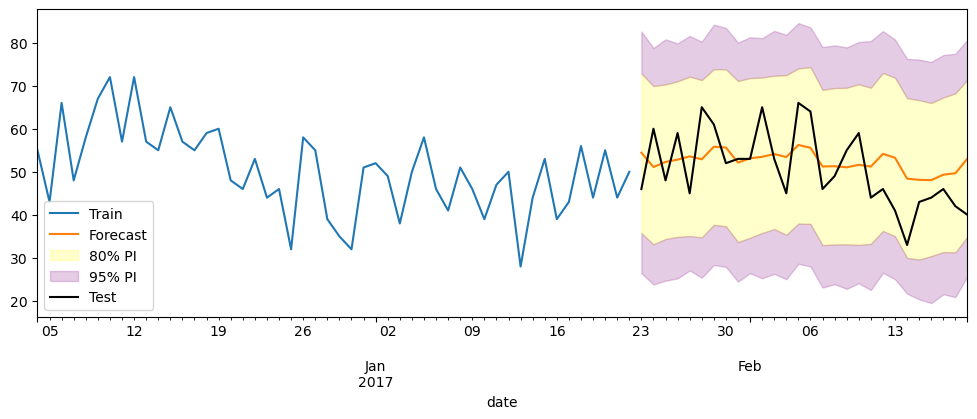

In [119]:
prophet_resid_mean = prophet_mean + resid_mean
prophet_resid_pi1 = prophet_pi1 + resid_pi1
prophet_resid_pi2 = prophet_pi2 + resid_pi2

plot_prediction_intervals(train[-50:], prophet_resid_mean, prophet_resid_pi1,
                          prophet_resid_pi2, test=test,
                          pi_labels=['80% PI', '95% PI'])

In [120]:
# Winkler score for 80% prediction interval
resid_80_ws = winkler_from_pi(prophet_resid_pi1, test, to_print=True)
# Winkler score for 95% prediction interval
resid_95_ws = winkler_from_pi(prophet_resid_pi2, test, alpha=0.05,
                              to_print=True)

Winkler score (80.0% PI): 36.51
Winkler score (95.0% PI): 55.69
